In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import norm
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.model_selection import KFold
import random
import copy

In [2]:
# Reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)

# Function Implementations

In [3]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")

def dataprep(data, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catdata = []
    for i in range(len(categoricals)):
        catdata.append(data[categoricals[i]].cat.codes.values)
    catdata = torch.tensor(catdata, dtype = torch.int64).T
    
    
    numdata = np.stack([data[col].values for col in numericals], 1)
    numdata = torch.tensor(numdata, dtype=torch.float)

    normalize(numdata, norm_type)
    return catdata, numdata

def make_dat(url,shuffle=False):
    if shuffle == True:
        df = pd.read_csv(url)
        return df.reindex(np.random.permutation(df.index))
    else:
        return pd.read_csv(url)

def BiasCorrection(points, probs1, probs2, true1, true2, kind = "equalized odds"):
    step = 1/points
    thresholds = np.arange(0,1+step,step)

    tprs1 = []
    fprs1 = []
    tprs2 = []
    fprs2 = []
    for i in range(points+1):
        y_pred1 = (probs1 > thresholds[i]).float()
        y_pred2 = (probs2 > thresholds[i]).float()
        conf1 = confusion_matrix(true1, y_pred1)
        conf2 = confusion_matrix(true2, y_pred2)

        tprs1.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
        fprs1.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
        tprs2.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
        fprs2.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))

    # Find the thresholds with the same tpr and fpr
    tprdiff = []
    fprdiff = []
    thresholds1 = []
    thresholds2 = []

    for i in range(len(thresholds)):
        tprval1 = tprs1[i]
        fprval1 = fprs1[i]
        threshold1 = thresholds[i]
        tprindex2 = min(range(len(tprs2)), key=lambda x: abs(tprs2[x]-tprval1))
        threshold2 = thresholds[tprindex2]
        tprval2 = tprs2[tprindex2]
        fprval2 = fprs2[tprindex2]
        tprdiff.append(abs(tprval1 - tprval2))
        fprdiff.append(abs(fprval1 - fprval2))
        thresholds1.append(threshold1)
        thresholds2.append(threshold2)
    
    # Plot of FPR and TPR values against thresholds
    plt.plot(thresholds1, fprs1, color = "blue", label = "Caucasian FPR")
    plt.plot(thresholds2, fprs2, color = "green", label = "African-American FPR")
    plt.plot(thresholds1, tprs1, "--", color = "blue", label = "Caucasian TPR")
    plt.plot(thresholds2, tprs2, "--", color = "green", label = "African-American TPR")
    plt.legend()
    plt.xlabel("Threshold")
    plt.ylabel("False/True Positive Rate")
    plt.title("False/True Positive Rate Dependency on Threshold")
    plt.show()
    
    if kind == "equalized odds":
        # Find the best accuracy that satisfies equalized odds
        num_excluded_points = int(points * 0.24)
        accs = []
        x1s = []
        x2s = []
        y1s = []
        y2s = []
        slopes = []
        for j in range(points - num_excluded_points + 1):

            # Find the corrosponding tpr and fpr values and use this to make a line
            point_idx = int(j + num_excluded_points/2 + num_excluded_points/25)
            slope = tprs2[point_idx] / fprs2[point_idx]
            slopes.append(slope)
            
            # Sample points on this new line
            line = lambda x: slope * x

            # Find the intersection of the line and the upper curve
            np.set_printoptions(suppress=True)
            linediff = abs(tprs1 - line(np.asarray(fprs1, dtype = "float64")))
            intersection_index = np.argmin(linediff[line(np.asarray(fprs1, dtype = "float64")) > tprs2[point_idx]])

            x1 = fprs1[intersection_index]
            x2 = fprs2[point_idx]
            y1 = tprs1[intersection_index]
            y2 = tprs2[point_idx]
            x1s.append(x1)
            x2s.append(x2)
            y1s.append(y1)
            y2s.append(y2)
            
            # Find the lengths of the lines between 0,0 and the new point on the upper line
            thres1 = 1.0
            thres2 = thresholds1[intersection_index]
            full_length = np.sqrt(y1**2 + x1**2)
            first_length = np.sqrt(y2**2 + x2**2)
            second_length = full_length - first_length
            # Make the predictions
            sample_threshold = first_length / (first_length + second_length)
            y_pred1_low = (probs1 > thres1).float()
            y_pred1_high = (probs1 > thres2).float()
            y_pred1 = [None] * len(probs1)
            for i in range(len(y_pred1)):
                sample_value = np.random.uniform(0,1,1)
                if sample_value > sample_threshold:
                    y_pred1[i] = y_pred1_low[i]
                else:
                    y_pred1[i] = y_pred1_high[i]
            y_pred2 = (probs2 > thresholds2[point_idx]).float()
            conf1 = confusion_matrix(true1, y_pred1)
            conf2 = confusion_matrix(true2, y_pred2)
            acc = (conf1[0,0] + conf1[1,1] + conf2[0,0] + conf2[1,1]) / (len(y_pred1) + len(y_pred2))
            accs.append(acc)
        
        # Plotting the ROC-curves on their own
        plt.plot(fprs1,tprs1,color="blue", label = "Caucasian")
        plt.plot(fprs2,tprs2,color="green", label = "African-American")
        x_values = [0, 1] 
        y_values = [0, 1]
        plt.plot(x_values, y_values,'--',color="red")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.ylim(0, 1.1)
        plt.title("Caucasian and African-American ROC-Curves")
        plt.legend(loc = "lower right")
        plt.show()
        
        # Plotting the initial positions of the green and blue points
        plt.plot(fprs1,tprs1,color="blue", label = "Female")
        plt.plot(fprs2,tprs2,color="green", label = "Male")
        x_values = [0, 1] 
        y_values = [0, 1]
        plt.plot(x_values, y_values,'--',color="red")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.ylim(0, 1.1)
        plt.legend(loc = "lower right")
        
        best_idx = np.argmax(accs)
        best_acc = accs[best_idx]
        x1 = x1s[best_idx]
        x2 = x2s[best_idx]
        y1 = y1s[best_idx]
        y2 = y2s[best_idx]
        slope = slopes[best_idx]
        plt.scatter(x1, y1, c = "blue")
        plt.scatter(x2, y2, c = "green")
        
        line = line = lambda x: slope * x
        plt.plot(np.linspace(0,1,points+1), line(np.linspace(0,1,points+1)), "--")
        
        plt.title("Equalized Odds")
        plt.show()

        def morePoints(j):
            plt.plot(fprs1,tprs1,color="blue", label = "Female")
            plt.plot(fprs2,tprs2,color="green", label = "Male")
            x_values = [0, 1] 
            y_values = [0, 1]
            plt.plot(x_values, y_values,'--',color="red")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.ylim(0, 1.1)
            plt.legend(loc = "lower right")

            # Find the corrosponding tpr and fpr values and use this to make a line
            point_idx = int(j + num_excluded_points/2)
            slope = tprs2[point_idx] / fprs2[point_idx]

            # Sample points on this new line
            line = lambda x: slope * x
            plt.plot(np.linspace(0,1,points+1), line(np.linspace(0,1,points+1)), "--")

            # Find the intersection of the line and the upper curve
            np.set_printoptions(suppress=True)
            linediff = abs(tprs1 - line(np.asarray(fprs1, dtype = "float64")))
            intersection_index = np.argmin(linediff[line(np.asarray(fprs1, dtype = "float64")) > tprs2[point_idx]])

            # Find the lengths of the lines between 0,0 and the new point on the upper line
            thres1 = 1.0
            thres2 = thresholds1[intersection_index]
            full_length = np.sqrt(tprs1[intersection_index]**2 + fprs1[intersection_index]**2)
            first_length = np.sqrt(tprs2[point_idx]**2 + fprs2[point_idx]**2)
            second_length = full_length - first_length
            
            # Make the predictions
            sample_threshold = first_length / (first_length + second_length)
            y_pred1_low = (probs1 > thres1).float()
            y_pred1_high = (probs1 > thres2).float()
            y_pred1 = [None] * len(probs1)
            for i in range(len(y_pred1)):
                sample_value = np.random.uniform(0,1,1)
                if sample_value > sample_threshold:
                    y_pred1[i] = y_pred1_low[i]
                else:
                    y_pred1[i] = y_pred1_high[i]

            y_pred2 = (probs2 > thresholds2[point_idx]).float()
            conf2 = confusion_matrix(true2, y_pred2)
            conf1 = confusion_matrix(true1, y_pred1)
            yval = conf1[1,1] / (conf1[1,1] + conf1[1,0])
            xval = conf1[0,1] / (conf1[0,1] + conf1[0,0])
            plt.scatter(xval, yval, c="blue")
            plt.scatter(fprs2[point_idx], tprs2[point_idx], c="green")
            plt.title("Optimal Equalized Odds Threshold")
            plt.text(-0.02, 0.94, f"Accuracy = {best_acc:.3f}\nThreshold 1 = {int(100*round(sample_threshold,3))}% {thres1:.2f} and {int(100*round(1-sample_threshold,3))}% {thresholds1[intersection_index]:.2f}\nThreshold 2 = {thresholds2[point_idx]:.3f}")
            plt.show()

        interact(morePoints, j=widgets.IntSlider(min=int(0 + num_excluded_points/2),max=int(points - num_excluded_points/2 - 2),step=1,value=best_idx))
    
    elif kind == "equal opportunity":
        accs = []
        new_thres1 = []
        new_thres2 = []
        x1s = []
        x2s = []
        y1s = []
        y2s = []
        for point in range(points + 1):
            
            y2 = tprs2[point]
            ydiff = abs(y2 - tprs1)
            intersection_idx = np.argmin(ydiff)
            y1 = tprs1[intersection_idx]
            x2 = fprs2[point]
            x1 = fprs1[intersection_idx]
            
            x1s.append(x1)
            x2s.append(x2)
            y1s.append(y1)
            y2s.append(y2)
            
            thres1 = thresholds1[intersection_idx]
            thres2 = thresholds2[point]
            new_thres1.append(thres1)
            new_thres2.append(thres2)

            y_pred1 = (probs1 > thres1).float()
            y_pred2 = (probs2 > thres2).float()
            conf1 = confusion_matrix(true1, y_pred1)
            conf2 = confusion_matrix(true2, y_pred2)
            acc = (conf1[0,0] + conf1[1,1] + conf2[0,0] + conf2[1,1]) / (len(y_pred1) + len(y_pred2))
            accs.append(acc)
        best_idx = np.argmax(accs)
        best_acc = accs[best_idx]
        best_thres1 = new_thres1[best_idx]
        best_thres2 = new_thres2[best_idx]
        
        # Plotting the ROC-curves on their own
        plt.plot(fprs1,tprs1,color="blue", label = "Caucasian")
        plt.plot(fprs2,tprs2,color="green", label = "African-American")
        x_values = [0, 1] 
        y_values = [0, 1]
        plt.plot(x_values, y_values,'--',color="red")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Caucasian and African-American ROC-Curves")
        plt.ylim(0, 1.1)
        plt.legend(loc = "lower right")
        plt.show()
        
        # Plotting of the points with equal tpr and finding accuracy for these thresholds
        plt.plot(fprs1,tprs1,color="blue", label = "Caucasian")
        plt.plot(fprs2,tprs2,color="green", label = "African-American")
        x_values = [0, 1] 
        y_values = [0, 1]
        plt.plot(x_values, y_values,'--',color="red")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.ylim(0, 1.1)
        plt.legend(loc = "lower right")

        x1 = x1s[best_idx]
        x2 = x2s[best_idx]
        y1 = y1s[best_idx]
        y2 = y2s[best_idx]
        plt.scatter(np.array([x1,x2]), np.array([y1,y2]), color = ["blue", "green"])
        if x1 > x2:
            xline = np.linspace(x2, x1, num = 2)
        else:
            xline = np.linspace(x1, x2, num = 2)
        yline = np.asarray([y2] * len(xline))
        plt.plot(xline, yline, "--", color = "red")
        
        plt.title("Best Equal Opportunity Threshold")
        plt.text(-0.02, 0.93, f"Accuracy = {best_acc:.3f}\nThreshold 1 = {best_thres1:.2f}\nThreshold 2 = {best_thres2:.3f}")
        plt.show()
    
    elif kind == "proof":
        
        # Find the lowest value of the two curves for each point
        lower = np.array([])
        for i in range(points + 1):
            if tprs1[i] > tprs2[i]:
                lower = np.append(lower, tprs2[i])
            else:
                lower = np.append(lower, tprs1[i])
        diag = np.linspace(0, 1, points + 1)
        
        # Plot the standard ROC-curve with the convex hull outlined
        convexes = np.vstack((fprs2, tprs2))
        convexes = np.transpose(convexes, (1,0))
        hull = ConvexHull(convexes)
        #plt.plot(convexes[:,0], convexes[:,1], 'o')
        #for simplex in hull.simplices:
        #    plt.plot(convexes[simplex, 0], convexes[simplex, 1], 'k-')
        
        fig, ax = plt.subplots(1)
        ax.plot(fprs1,tprs1,color="blue")
        ax.plot(fprs2,tprs2,color="green")
        x_values = [0, 1] 
        y_values = [0, 1]
        ax.plot(x_values, y_values,'--',color="red")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title("ROC Curve Convex Hull")
        ax.set_ylim(0, 1.1)
        plt.fill(convexes[hull.vertices,0], convexes[hull.vertices,1], 'k', alpha=0.3)
        plt.show()

# Data Visualization and Pre-processing

In [4]:
# Load data and remove every race except Caucasians and African-Americans
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
data = make_dat(url,shuffle=False)
data = data[(data["race"] == "Caucasian") | (data["race"] == "African-American")]

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#print(data.columns)

No GPU available.


## Visualization of Data

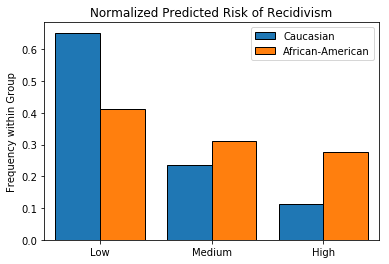

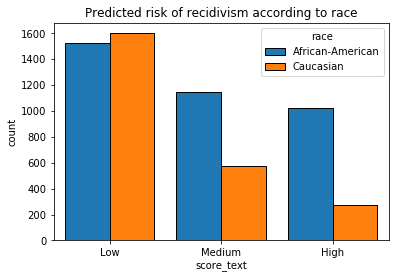

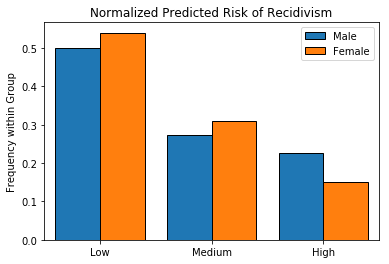

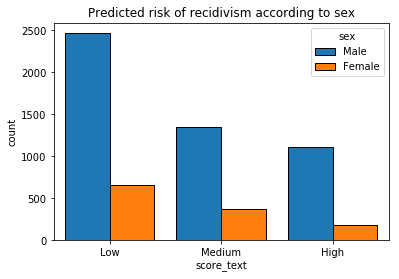

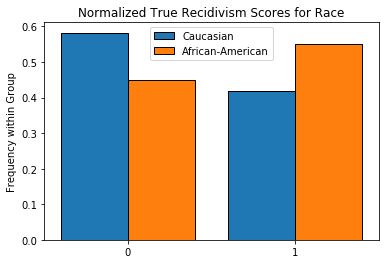

[[0.58231459 0.41768541]
 [0.4491342  0.5508658 ]]


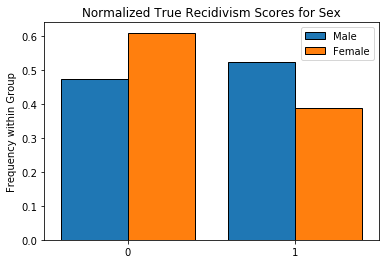

[[0.47535997 0.52464003]
 [0.61115669 0.38884331]]


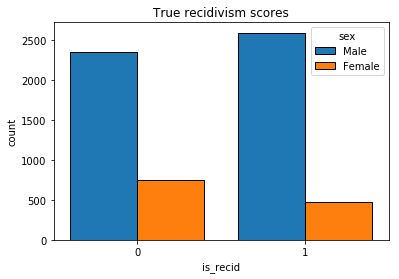

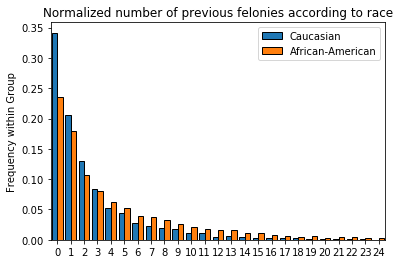

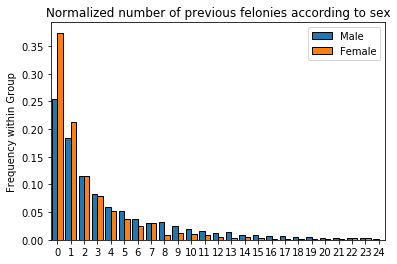

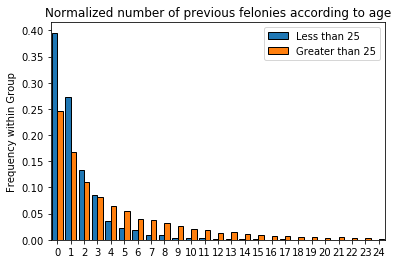

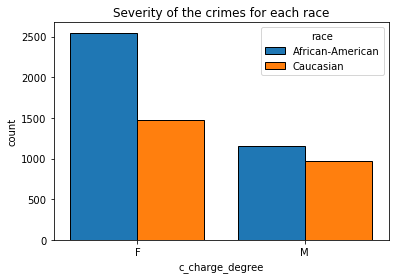

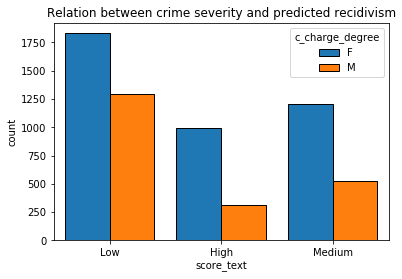

In [5]:
# Show the normalized proportions of the black and white in the categories of score_text
race_score_vals = ["Low", "Medium", "High"]
race_vals = ["Caucasian", "African-American"]
race_distribution = np.empty([2,3])
for i, race in enumerate(race_vals):
    for j, score in enumerate(race_score_vals):
        race_distribution[i,j] = len(data[(data["race"] == race) & (data["score_text"] == score)]) / len(data[data["race"] == race])

race_distribution = race_distribution.flatten()
hue = ["Caucasian","Caucasian","Caucasian","African-American","African-American","African-American"]
sb.barplot(["Low","Medium","High","Low","Medium","High"], race_distribution, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
plt.ylabel("Frequency within Group")
plt.title("Normalized Predicted Risk of Recidivism")
plt.show()

# Show the number of black and white in categories of score_text
pred_plot_race = sb.countplot(x = "score_text", order = ['Low', 'Medium', 'High'], hue = "race", data = data, edgecolor=(0,0,0), linewidth=1, saturation = 1)                
pred_plot_race.set_title("Predicted risk of recidivism according to race")
plt.show()


# Show the normalized proportions of male and female in the categories of score_text
sex_score_vals = ["Low", "Medium", "High"]
sex_vals = ["Male", "Female"]
sex_distribution = np.empty([2,3])
for i, sex in enumerate(sex_vals):
    for j, score in enumerate(sex_score_vals):
        sex_distribution[i,j] = len(data[(data["sex"] == sex) & (data["score_text"] == score)]) / len(data[data["sex"] == sex])

sex_distribution = sex_distribution.flatten()
hue = ["Male","Male","Male","Female","Female","Female"]
sb.barplot(["Low","Medium","High","Low","Medium","High"], sex_distribution, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
plt.ylabel("Frequency within Group")
plt.title("Normalized Predicted Risk of Recidivism")
plt.show()

# Show the number of male and female in categories of score_text
pred_plot_sex = sb.countplot(x = "score_text", order = ['Low', 'Medium', 'High'], hue = "sex", data = data, edgecolor=(0,0,0), linewidth=1, saturation = 1)
pred_plot_sex.set_title("Predicted risk of recidivism according to sex")
plt.show()

# Show the normalized proportions of black and white in the categories of is_recid
race_score_vals = [0, 1]
race_vals = ["Caucasian", "African-American"]
race_distribution = np.empty([2,2])
for i, race in enumerate(race_vals):
    for j, score in enumerate(race_score_vals):
        race_distribution[i,j] = len(data[(data["race"] == race) & (data["is_recid"] == score)]) / len(data[data["race"] == race])

race_distributions = race_distribution.flatten()
hue = ["Caucasian","Caucasian","African-American","African-American"]
sb.barplot([0,1,0,1], race_distributions, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
plt.ylabel("Frequency within Group")
plt.title("Normalized True Recidivism Scores for Race")
plt.show()
print(race_distribution)

# Show the normalized proportions of male and female in the categories of is_recid
sex_score_vals = [0, 1]
sex_vals = ["Male", "Female"]
sex_distribution = np.empty([2,2])
for i, sex in enumerate(sex_vals):
    for j, score in enumerate(sex_score_vals):
        sex_distribution[i,j] = len(data[(data["sex"] == sex) & (data["is_recid"] == score)]) / len(data[data["sex"] == sex])

sex_distributions = sex_distribution.flatten()
hue = ["Male","Male","Female","Female"]
sb.barplot([0,1,0,1], sex_distributions, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
plt.ylabel("Frequency within Group")
plt.title("Normalized True Recidivism Scores for Sex")
plt.show()
print(sex_distribution)

# Plot of true recidivism scores for sex
true_plot = sb.countplot(x = "is_recid", hue = "sex", data = data, edgecolor=(0,0,0), linewidth=1, saturation = 1)
true_plot.set_title("True recidivism scores")
plt.show()

# Show the normalized number of priors count for caucasian and african-american
race_score_vals = np.linspace(0,24,25)
race_score_vals = [int(x) for x in race_score_vals]
race_vals = ["Caucasian", "African-American"]
race_distribution = np.empty([2,25])
for i, race in enumerate(race_vals):
    for j, score in enumerate(race_score_vals):
        race_distribution[i,j] = len(data[(data["race"] == race) & (data["priors_count"] == score)]) / len(data[data["race"] == race])

race_distribution = race_distribution.flatten()
huee = ["Caucasian"] * 25
hue = ["African-American"] * 25
hue = huee + hue
sb.barplot(np.concatenate((race_score_vals, race_score_vals), axis=0), race_distribution, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
plt.ylabel("Frequency within Group")
plt.title("Normalized number of previous felonies according to race")
plt.show()

# Show the normalized number of priors count for male and female
sex_score_vals = np.linspace(0,24,25)
sex_score_vals = [int(x) for x in sex_score_vals]
sex_vals = ["Male", "Female"]
sex_distribution = np.empty([2,25])
for i, sex in enumerate(sex_vals):
    for j, score in enumerate(sex_score_vals):
        sex_distribution[i,j] = len(data[(data["sex"] == sex) & (data["priors_count"] == score)]) / len(data[data["sex"] == sex])

sex_distribution = sex_distribution.flatten()
huee = ["Male"] * 25
hue = ["Female"] * 25
hue = huee + hue
sb.barplot(np.concatenate((sex_score_vals, sex_score_vals), axis=0), sex_distribution, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
plt.ylabel("Frequency within Group")
plt.title("Normalized number of previous felonies according to sex")
plt.show()


# Show the normalized number of priors count for under and over 25 years old
df = data.copy()
df["age_cat"] = df["age_cat"].replace("Less than 25", "Less than 25")
df["age_cat"] = df["age_cat"].replace("25 - 45", "Greater than 25")
df["age_cat"] = df["age_cat"].replace("Greater than 45", "Greater than 25")
age_score_vals = np.linspace(0,24,25)
age_score_vals = [int(x) for x in age_score_vals]
age_vals = ["Less than 25", "Greater than 25"]
age_distribution = np.empty([2,25])
for i, age in enumerate(age_vals):
    for j, score in enumerate(age_score_vals):
        age_distribution[i,j] = len(df[(df["age_cat"] == age) & (df["priors_count"] == score)]) / len(df[df["age_cat"] == age])

age_distribution = age_distribution.flatten()
huee = ["Less than 25"] * 25
hue = ["Greater than 25"] * 25
hue = huee + hue
sb.barplot(np.concatenate((age_score_vals, age_score_vals), axis=0), age_distribution, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
plt.ylabel("Frequency within Group")
plt.title("Normalized number of previous felonies according to age")
plt.show()

# How severe crime was based on the race of the offender
c_charge_degree = sb.countplot(x = "c_charge_degree", hue = "race", data = df, edgecolor=(0,0,0), linewidth=1, saturation = 1)
c_charge_degree.set_title("Severity of the crimes for each race")
plt.show()

# Relationship between severity of crime and score_text value
c_charge_degree = sb.countplot(x = "score_text", hue = "c_charge_degree", data = df, edgecolor=(0,0,0), linewidth=1, saturation = 1)
c_charge_degree.set_title("Relation between crime severity and predicted recidivism")
plt.show()

## Show number of defendants in each group for any variable in the data

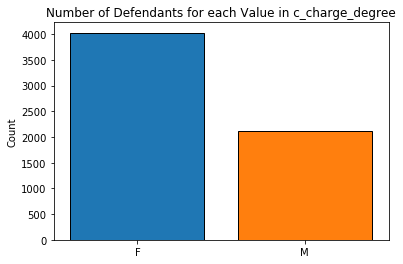

In [6]:
from matplotlib import ticker

var = "c_charge_degree"
vals = np.sort(data[var].unique())
nums = np.array([])
for val in vals:
    nums = np.append(nums, len(data[data[var] == val]))

chart = sb.barplot(vals, nums, data = data, edgecolor=(0,0,0), linewidth=1, saturation = 1)
if len(vals) > 25:
    chart.xaxis.set_major_locator(ticker.MultipleLocator(5))
    chart.xaxis.set_major_formatter(ticker.ScalarFormatter())
elif len(vals) > 10:
    chart.set_xticklabels(chart.get_xticklabels(), rotation=-45, horizontalalignment='center', fontsize="small")
plt.ylabel("Count")
plt.title(f"Number of Defendants for each Value in {var}")
plt.show()

In [7]:
# Define subsection of data to use for classification
categoricals = ["c_charge_degree", "race", "age_cat", "sex"]    
numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"]
outputs = ["score_text"]
features = categoricals + numericals
data = data[features + outputs + ["two_year_recid"] + ["is_recid"]]

# Binarizing output
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")

Xcat, Xnum = dataprep(data, norm_type = "zscore")

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)
Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
y = torch.tensor(data[outputs].values).flatten()
ytrain = y[:totalnumber - testnumber]
ytest = data["is_recid"][totalnumber - testnumber:totalnumber]
ytest = torch.tensor(ytest.values).flatten()

# Normalizing numerical values after splitting into test and train
normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

In [8]:
decile_data = make_dat(url,shuffle=False)
decile_data = decile_data[(decile_data["race"] == "Caucasian") | (decile_data["race"] == "African-American")]
decile_score = decile_data["decile_score"]

# Neural Network

In [9]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return torch.sigmoid(x)

## Define the Model

In [10]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(2, 1)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64,

## Hyperparameters and Loss

In [11]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5
epochs = 400

## Train the Model

epoch:   1 loss: 0.77376384
epoch:  26 loss: 0.66323167
epoch:  51 loss: 0.61245477
epoch:  76 loss: 0.58707857
epoch: 101 loss: 0.57602012
epoch: 126 loss: 0.56471962
epoch: 151 loss: 0.55777633
epoch: 176 loss: 0.54900312
epoch: 201 loss: 0.54390180
epoch: 226 loss: 0.54554421
epoch: 251 loss: 0.54797083
epoch: 276 loss: 0.53937638
epoch: 301 loss: 0.54334533
epoch: 326 loss: 0.53655028
epoch: 351 loss: 0.53733557
epoch: 376 loss: 0.53543222
epoch: 400 loss: 0.5323563814


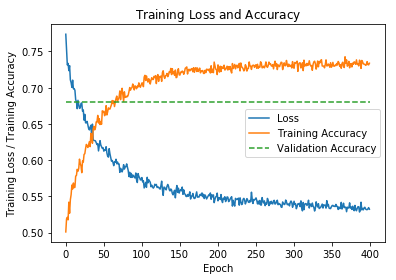

[[457 158]
 [235 380]]
[[0.372 0.128]
 [0.191 0.309]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       615
           1       0.71      0.62      0.66       615

    accuracy                           0.68      1230
   macro avg       0.68      0.68      0.68      1230
weighted avg       0.68      0.68      0.68      1230

0.6804878048780488


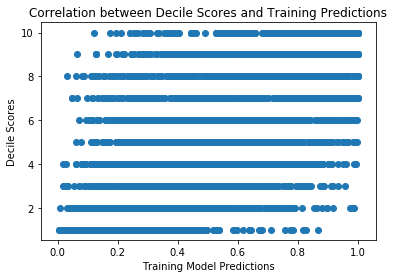

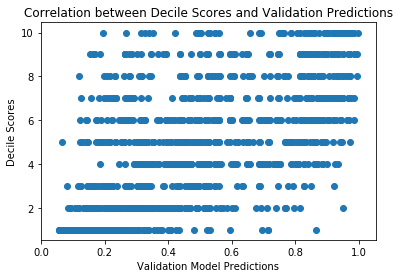

In [12]:


# Initialize lists for training and validation
aggregated_losses = []
train_accs = []

# Training loop
model.train()
for i in range(epochs):
    i += 1
    y_preds = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_preds, ytrain.float().view(-1,1))
    aggregated_losses.append(single_loss)
    y_pred = (y_preds > threshold).float()
    train_accs.append(accuracy_score(ytrain, y_pred))

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# Constructing plot of loss/accuracy over epochs
neural_xs = range(epochs)
neural_ys1 = aggregated_losses
neural_ys2 = train_accs
plt.plot(neural_xs, neural_ys1 , label="Loss")

plt.plot(neural_xs, neural_ys2, label = "Training Accuracy" )
plt.ylabel('Training Loss / Training Accuracy')
plt.xlabel('Epoch');
plt.title(r'$\mathrm{Training \ Loss \ and \ Accuracy}$')

# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest.float().view(-1, 1))

y_pred = (y_val > threshold).float()

conf = confusion_matrix(ytest,y_pred)
conf_norm = np.copy(conf).astype(float)
N = conf.sum()
conf_norm = conf / N

# Validation accuracy for loss/accuracy plot
neural_acc = accuracy_score(ytest, y_pred)
xs = [0,400]
ys = [neural_acc, neural_acc]
plt.plot(xs, ys, "--", label = "Validation Accuracy")
plt.legend()
plt.show()

print(conf)
print(np.around(conf_norm, 3))
print(classification_report(ytest,y_pred))
print(neural_acc)

# Plot correlation between train outoput and decile scores
plt.scatter(y_preds.detach().numpy(), decile_score[0:totalnumber - testnumber])
plt.title("Correlation between Decile Scores and Training Predictions")
plt.xlabel("Training Model Predictions")
plt.ylabel("Decile Scores")
plt.show()

# Plot correlation between test outoput and decile scores
plt.scatter(y_val, decile_score[totalnumber - testnumber:totalnumber])
plt.title("Correlation between Decile Scores and Validation Predictions")
plt.xlabel("Validation Model Predictions")
plt.ylabel("Decile Scores")
plt.show()

# Standard Deviation for Accuracy

This next cell takes a long time to run, so we recommend using HPC like Google Colab's TPU runtime.

epoch:   1 loss: 0.72173256
epoch: 101 loss: 0.57321149
epoch: 201 loss: 0.55965281
epoch: 301 loss: 0.54319358
0.6731707317073171
epoch:   1 loss: 0.75227964
epoch: 101 loss: 0.58964014
epoch: 201 loss: 0.54625463
epoch: 301 loss: 0.53727430
0.7040650406504065
epoch:   1 loss: 0.76586348
epoch: 101 loss: 0.59001929
epoch: 201 loss: 0.55609328
epoch: 301 loss: 0.54965979
0.6780487804878049
epoch:   1 loss: 0.77497178
epoch: 101 loss: 0.57426828
epoch: 201 loss: 0.55177462
epoch: 301 loss: 0.54060239
0.6829268292682927
epoch:   1 loss: 0.77686709
epoch: 101 loss: 0.58372593
epoch: 201 loss: 0.55490524
epoch: 301 loss: 0.54521239
0.6455284552845528
epoch:   1 loss: 0.73710346
epoch: 101 loss: 0.58876073
epoch: 201 loss: 0.55732155
epoch: 301 loss: 0.54333317
0.6601626016260163
epoch:   1 loss: 0.74772954
epoch: 101 loss: 0.57155561
epoch: 201 loss: 0.55243576
epoch: 301 loss: 0.54278868
0.6731707317073171
epoch:   1 loss: 0.75169194
epoch: 101 loss: 0.58302695
epoch: 201 loss: 0.56290120

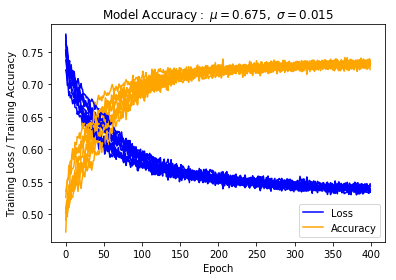

In [13]:
kf = KFold(n_splits=10)

model_accs = []
j = 0
for train_index, test_index in kf.split(Xcat):
    # Define each of the train/test splits to be used in the model
    Xcattrain, Xcattest = Xcat[train_index], Xcat[test_index]
    Xnumtrain, Xnumtest = Xnum[train_index], Xnum[test_index]
    data_np = np.asarray(data["is_recid"])
    ytrain, ytest = y[train_index], data_np[test_index]

    normalize(Xnumtrain, "zscore");
    normalize(Xnumtest, "zscore");
    
    ytest = torch.tensor(ytest)

    # Initialize lists for training and validation
    aggregated_losses = []
    train_iter = []
    train_loss, train_accs = [], []
    
    # Initialize model
    model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
    if use_cuda:
      model.cuda()
      print(model)
    for param in model.parameters():
      param.requires_grad = True
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
    epochs = 400
    
    # Train model
    model.train()
    for i in range(epochs):
        i += 1
        y_pred = model(Xcattrain, Xnumtrain)
        single_loss = loss_function(y_pred, ytrain.float().view(-1,1))
        aggregated_losses.append(single_loss)
        y_pred = (y_pred > threshold).float()
        train_accs.append(accuracy_score(ytrain, y_pred))
        if i % 100 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

    # Predict on the test set
    model.eval()
    with torch.no_grad():
        y_val = model(Xcattest,Xnumtest)
    y_valpred = (y_val > threshold).float()
    print(accuracy_score(ytest, y_valpred))
    model_accs.append(accuracy_score(ytest, y_valpred))
    
    # Plot every loss/accuracy curve
    if j == 9:
        mu, sd = np.mean(model_accs), np.std(model_accs)
        plt.title(r'$\mathrm{Model \ Accuracy:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sd))
        plt.plot(range(epochs), aggregated_losses, color = "blue", label = "Loss")
        plt.plot(range(epochs), train_accs, color = "orange", label = "Accuracy")
        plt.ylabel('Training Loss / Training Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
    else:
        plt.plot(range(epochs), aggregated_losses, color = "blue")
        plt.plot(range(epochs), train_accs, color = "orange")
    j += 1

## Loss Curve with Standard Deviation

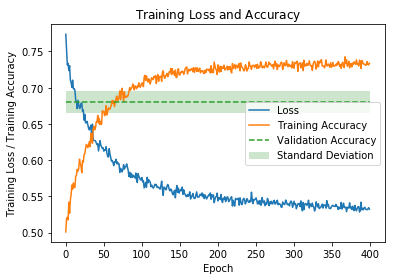

In [20]:
fig, ax = plt.subplots(1)
ax.plot(neural_xs, neural_ys1 , label="Loss")
ax.plot(neural_xs, neural_ys2, label = "Training Accuracy" )
ax.set_ylabel('Training Loss / Training Accuracy')
ax.set_xlabel('Epoch');
ax.set_title(r'$\mathrm{Training \ Loss \ and \ Accuracy}$')

s1 = neural_acc + np.std(model_accs)
s2 = neural_acc - np.std(model_accs)

xs = [0,epochs]
ys = [neural_acc, neural_acc]
ax.plot(xs, ys, "--", label = "Final Validation Accuracy")
ax.fill_between(xs, s1, s2, alpha = 0.2, facecolor = "green", label = "Final Standard Deviation")
ax.legend(loc = "center right")
plt.show()

# Permutation Test for Accuracy

This also takes quite long to run, so please use HPC for this too. The $\mu$ and $\sigma$ in the plot is the mean and standard deviation of the permuted features, not the accuracy.

In [17]:
model_nums = 200
perm_accs = np.asarray([])
for i in range(model_nums):  
    perm_data = copy.deepcopy(data)
    #perm_data[["is_recid"] + ["score_text"]] = np.random.shuffle(perm_data[["is_recid"] + ["score_text"]])
    perm_data[["is_recid"] + ["score_text"]] = np.random.permutation(perm_data[["is_recid"] + ["score_text"]])
    ytrain, ytest = perm_data["score_text"][:totalnumber - testnumber], perm_data["is_recid"][totalnumber - testnumber:totalnumber]
    ytrain = torch.tensor(ytrain.values)
    ytest = torch.tensor(ytest.values)
    
    # Initialize lists for training and validation
    aggregated_losses = []
    train_iter = []
    train_loss, train_accs = [], []
    
    # Initialize model
    model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
    if use_cuda:
      model.cuda()
      print(model)
    for param in model.parameters():
      param.requires_grad = True
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
    epochs = 400
    
    # Train model
    model.train()
    for i in range(epochs):
        i += 1
        y_pred = model(Xcattrain, Xnumtrain)
        single_loss = loss_function(y_pred, ytrain.float().view(-1,1))
        aggregated_losses.append(single_loss)
        y_pred = (y_pred > threshold).float()
        train_accs.append(accuracy_score(ytrain, y_pred))
        if i % 100 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

    # Predict on the test set
    model.eval()
    with torch.no_grad():
        y_val = model(Xcattest,Xnumtest)
    y_valpred = (y_val > threshold).float()
    print(accuracy_score(ytest, y_valpred))
    perm_accs = np.append(perm_accs, accuracy_score(ytest, y_valpred))

epoch:   1 loss: 0.75208807
epoch: 101 loss: 0.69762206
epoch: 201 loss: 0.69335836
epoch: 301 loss: 0.69291079
0.5097560975609756
epoch:   1 loss: 0.76140738
epoch: 101 loss: 0.69818300
epoch: 201 loss: 0.69373465
epoch: 301 loss: 0.69302052
0.4682926829268293


## Plot of Permuted Accuracies 

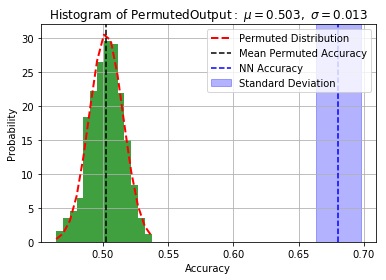

NameError: name 'model_accs' is not defined

In [50]:
fig, ax = plt.subplots(1)
(mu, sigma) = norm.fit(perm_accs)
n, bins, patches = ax.hist(perm_accs,14, facecolor='green', alpha=0.75,density=True)
y = norm.pdf(bins, mu, sigma)
ax.plot(bins, y, 'r--', linewidth=2, label = "Permuted Distribution")
ax.axvline(x=mu, color='k', linestyle='--', label = "Mean Permuted Accuracy")
ax.axvline(x=neural_acc, color='b', linestyle='--', label = "NN Accuracy")
s1 = neural_acc + 0.017
s2 = neural_acc - 0.017
#s1 = neural_acc + np.std(model_accs)
#s2 = neural_acc - np.std(model_accs)
ax.axvspan(s1, s2, alpha=0.3, color='blue', label = "Standard Deviation")
ax.set_xlabel('Accuracy')
ax.set_ylabel('Probability')
ax.set_title(r'$\mathrm{Histogram\ of\ Permuted Output:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
ax.legend(loc = "upper right")
ax.grid(True)
plt.show()
print(f" The FFNN accuracy standard deviation is {np.std(model_accs)}")

# Confusion matrices for Caucasians and African-Americans

This is the part of the code that will have to be augmented to find bias in the "sex" and "age" protected groups. testing for bias of sex works by simply replacing ```python black_data = df[df["race"]=="African-American"] ``` and ```python white_data = df[df["race"]=="Caucasian"] ``` with ``` black_data = df[df["sex"]=="Male"]``` and ```python white_data = df[df["sex"]=="Female"] ```. This works for age too, but for this project, the age_cat variables were first converted to "less_than_25" and "greater_than_25", so two ROC-curves can be constructed.

In [79]:
# Find predictions on protected groups

df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]
Xcat_white, Xnum_white = dataprep(white_data, norm_type = "zscore")
Xcat_black, Xnum_black = dataprep(black_data, norm_type = "zscore")
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_pred1 = (y_val_white > 0.5).float()
y_val_black = model(Xcat_black, Xnum_black)
y_pred2 = (y_val_black > 0.5).float()

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
y_black = torch.tensor(black_data["two_year_recid"].values).flatten()

# Find confusion matrices and normalized confusion matrices
conf_white = confusion_matrix( y_white, y_pred1)
conf_black = confusion_matrix( y_black, y_pred2)
conf_white_norm = np.copy(conf_white).astype(float)
conf_black_norm = np.copy(conf_black).astype(float)
N_white = conf_white.sum()
N_black = conf_black.sum()
conf_white_norm = conf_white / N_white
conf_black_norm = conf_black / N_black

print("Confussion matrix for the white:")
print(conf_white)
print(np.around(conf_white_norm, 3))
print()
print("Confussion matrix for the black:")
print(conf_black)
print(np.around(conf_black_norm, 3))

C:\Users\ejer\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Confussion matrix for the white:
[[199 103]
 [ 62 119]]
[[0.412 0.213]
 [0.128 0.246]]

Confussion matrix for the black:
[[259  92]
 [165 231]]
[[0.347 0.123]
 [0.221 0.309]]


# Neural Network Bias Correction

## Equal Opportunity

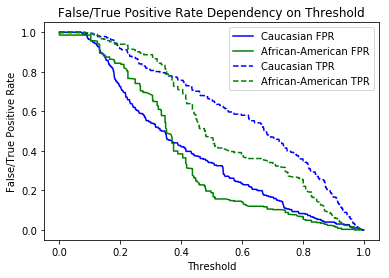

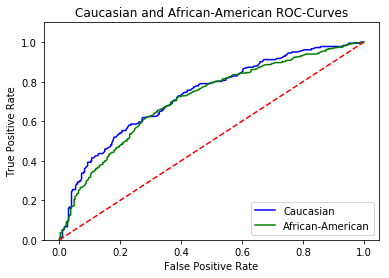

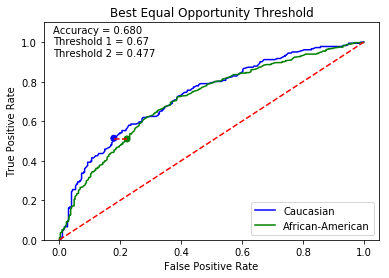

In [80]:
BiasCorrection(100, y_val_white, y_val_black, y_white, y_black, kind = "equal opportunity")

## Equalized Odds

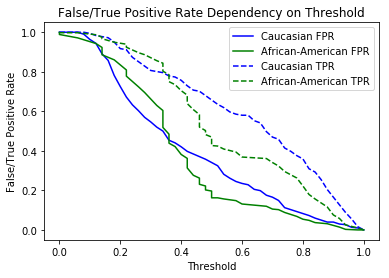

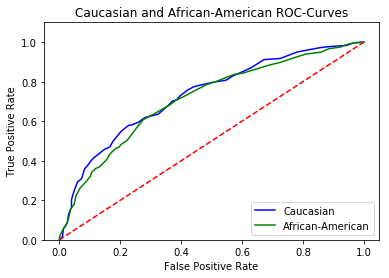

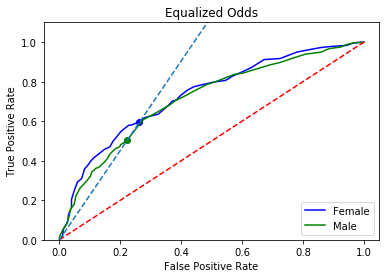

interactive(children=(IntSlider(value=21, description='j', max=42, min=6), Output()), _dom_classes=('widget-in…

In [82]:
BiasCorrection(100, y_val_white, y_val_black, y_white, y_black, kind = "equalized odds")

# Testing Bias in ProPublica

This section can also be generalized to work on the other protected groups.

## Using Decile Scores

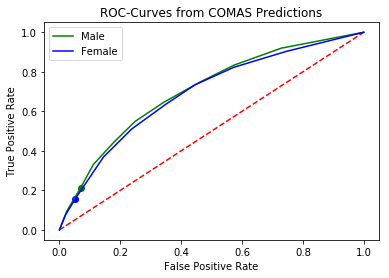

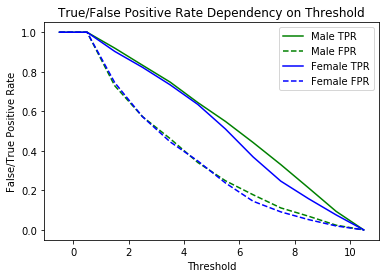

In [28]:
# Load data with decile scores
pub_data = make_dat(url,shuffle=False)
pub_data = pub_data[(pub_data["race"] == "Caucasian") | (pub_data["race"] == "African-American")]

points = 12
thresholds = np.linspace(-0.5,10.5,points)
black_tprs = []
black_fprs = []
white_tprs = []
white_fprs = []

# Find TPR and FPR value for each point on the curve
for i in range(points):
    threshold = thresholds[i]
    
    black_data = pub_data[pub_data["sex"]=="Male"]
    white_data = pub_data[pub_data["sex"]=="Female"]
    
    black_yval = torch.tensor(black_data["decile_score"].values)
    white_yval = torch.tensor(white_data["decile_score"].values)
    
    black_pred = (black_yval > threshold).float()
    white_pred = (white_yval > threshold).float()
    black_ytest = torch.tensor(black_data["is_recid"].values)
    white_ytest = torch.tensor(white_data["is_recid"].values)
    
    black_conf = confusion_matrix(black_ytest, black_pred)
    white_conf = confusion_matrix(white_ytest, white_pred)    
    
    black_tprs.append(black_conf[1,1] / (black_conf[1,1] + black_conf[1,0]))
    black_fprs.append(black_conf[0,1] / (black_conf[0,1] + black_conf[0,0]))
    white_tprs.append(white_conf[1,1] / (white_conf[1,1] + white_conf[1,0]))
    white_fprs.append(white_conf[0,1] / (white_conf[0,1] + white_conf[0,0]))

# Plot the ROC-curves of the two groups
line_val = [0,1]    
plt.plot(line_val, line_val, "r--")
plt.plot(black_fprs, black_tprs, "g-", label = "Male")
plt.plot(white_fprs, white_tprs, "b-", label = "Female")
plt.scatter(black_fprs[9], black_tprs[9], color = "green")
plt.scatter(white_fprs[9], white_tprs[9], color = "blue")
plt.title("ROC-Curves from COMAS Predictions")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot the FPR and TPR values as a function of threshold
plt.plot(thresholds, black_tprs, "g-", label = "Male TPR")
plt.plot(thresholds, black_fprs, "g--", label = "Male FPR")
plt.plot(thresholds, white_tprs, "b-", label = "Female TPR")
plt.plot(thresholds, white_fprs, "b--", label = "Female FPR")
plt.title("True/False Positive Rate Dependency on Threshold")
plt.xlabel("Threshold")
plt.ylabel("False/True Positive Rate")
plt.legend()
plt.show()

## Using Score Text

In [29]:
# Binarizing score text
pub_data["score_text"] = pub_data["score_text"].replace("Low", 0)
pub_data["score_text"] = pub_data["score_text"].replace("Medium", 1)
pub_data["score_text"] = pub_data["score_text"].replace("High", 1)

# Find confusion matrix and normalized confusion matrix for the only available point
black_data = pub_data[pub_data["sex"]=="Male"]
white_data = pub_data[pub_data["sex"]=="Female"]
black_yval = torch.tensor(black_data["score_text"].values)
white_yval = torch.tensor(white_data["score_text"].values)
black_ytest = torch.tensor(black_data["is_recid"].values)
white_ytest = torch.tensor(white_data["is_recid"].values)
black_conf = confusion_matrix(black_ytest, black_yval)
white_conf = confusion_matrix(white_ytest, white_yval)
white_conf_norm = np.copy(white_conf).astype(float)
black_conf_norm = np.copy(black_conf).astype(float)
N_white = white_conf.sum()
N_black = black_conf.sum()
white_conf_norm = white_conf / N_white
black_conf_norm = black_conf / N_black
print(white_conf_norm)
print(black_conf_norm)

[[0.3978671  0.21328958]
 [0.14191961 0.24692371]]
[[0.31312107 0.1622389 ]
 [0.18657473 0.3380653 ]]
